<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/main/recipes/geojson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Converting Kili label format to GeoJSON

In this recipe, we will see how to convert Kili label format to GeoJSON format.

First, let's install and import the required libraries:

In [ ]:
%pip install kili

In [ ]:
import json
import os
import urllib.request

from kili.client import Kili

In [ ]:
kili = Kili(
    # api_key=KILI_API_KEY,  # uncomment this line if KILI_API_KEY environment variable is not set
    # api_endpoint="https://cloud.kili-technology.com/api/label/v2/graphql",
    # the line above can be uncommented and changed if you are working with an on-premise version of Kili
)

## Data

For this tutorial, we will use a GeoTiff file created from Copernicus Sentinel-2A data.

In [ ]:
urllib.request.urlretrieve(
    "https://github.com/mommermi/geotiff_sample/raw/master/sample.tif", "sample.tif"
)

## Kili project creation

We will create a project with a single asset, the GeoTiff file we just downloaded.

In [ ]:
json_interface = {
    "jobs": {
        "BBOX_DETECTION_JOB": {
            "content": {
                "categories": {"B_BOX_A": {"children": [], "color": "#472CED", "name": "BBox A"}},
                "input": "radio",
            },
            "instruction": "BBox job",
            "mlTask": "OBJECT_DETECTION",
            "required": 1,
            "tools": ["rectangle"],
            "isChild": False,
        },
        "POINT_DETECTION_JOB": {
            "content": {
                "categories": {"POINT_A": {"children": [], "color": "#D33BCE", "name": "Point A"}},
                "input": "radio",
            },
            "instruction": "Point job",
            "mlTask": "OBJECT_DETECTION",
            "required": 1,
            "tools": ["marker"],
            "isChild": False,
        },
        "POLYGON_DETECTION_JOB": {
            "content": {
                "categories": {
                    "POLYGON_A": {"children": [], "color": "#3BCADB", "name": "Polygon A"}
                },
                "input": "radio",
            },
            "instruction": "Polygon job",
            "mlTask": "OBJECT_DETECTION",
            "required": 1,
            "tools": ["polygon"],
            "isChild": False,
        },
        "LINE_DETECTION_JOB": {
            "content": {
                "categories": {"LINE_A": {"children": [], "color": "#5CE7B7", "name": "Line A"}},
                "input": "radio",
            },
            "instruction": "Line job",
            "mlTask": "OBJECT_DETECTION",
            "required": 1,
            "tools": ["polyline"],
            "isChild": False,
        },
        "SEGMENTATION_JOB": {
            "content": {
                "categories": {
                    "SEGMENTATION_A": {"children": [], "color": "#FB753C", "name": "Segmentation A"}
                },
                "input": "radio",
            },
            "instruction": "Segmentation job",
            "mlTask": "OBJECT_DETECTION",
            "required": 1,
            "tools": ["semantic"],
            "isChild": False,
        },
    }
}

In [ ]:
project_id = kili.create_project(
    input_type="IMAGE", title="[Kili SDK Notebook]: Geojson tutorial", json_interface=json_interface
)["id"]

In [ ]:
kili.append_many_to_dataset(project_id, content_array=["sample.tif"], external_id_array=["sample"])

At this point, we can visualize the asset in Kili:

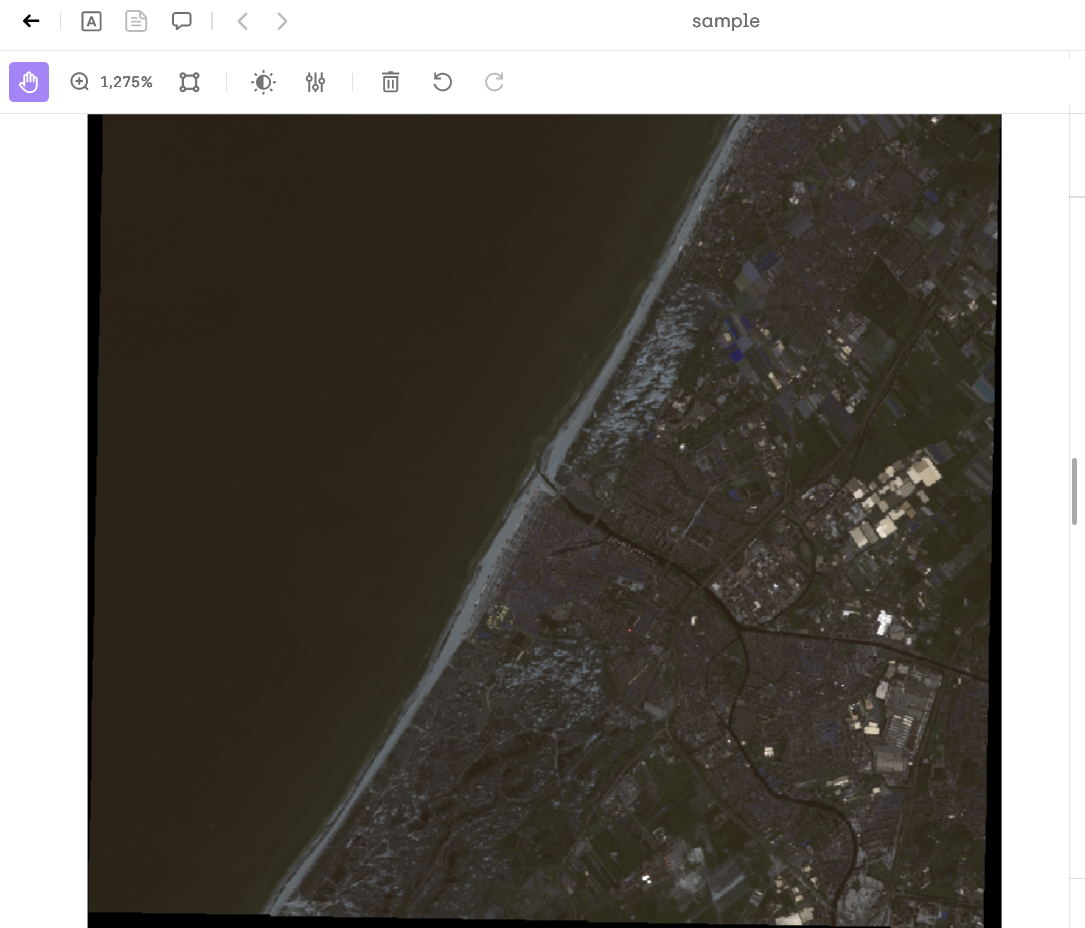

We can also visualize the same asset in geojson.io: [https://geojson.io/#map=11.98/52.2103/4.383](https://geojson.io/#map=11.98/52.2103/4.383)

For sake of simplicity, we will assume that the asset has already been labeled in Kili.

In [ ]:
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/kili-technology/kili-python-sdk/main/recipes/datasets/geojson_tutorial_kili_label.json",
    "geojson_tutorial_kili_label.json",
)

In [ ]:
with open("geojson_tutorial_kili_label.json") as f:
    json_response = json.load(f)

In [ ]:
kili.append_labels(
    json_response_array=[json_response], project_id=project_id, asset_external_id_array=["sample"]
)

We can see that the asset has been labeled with some geometries:

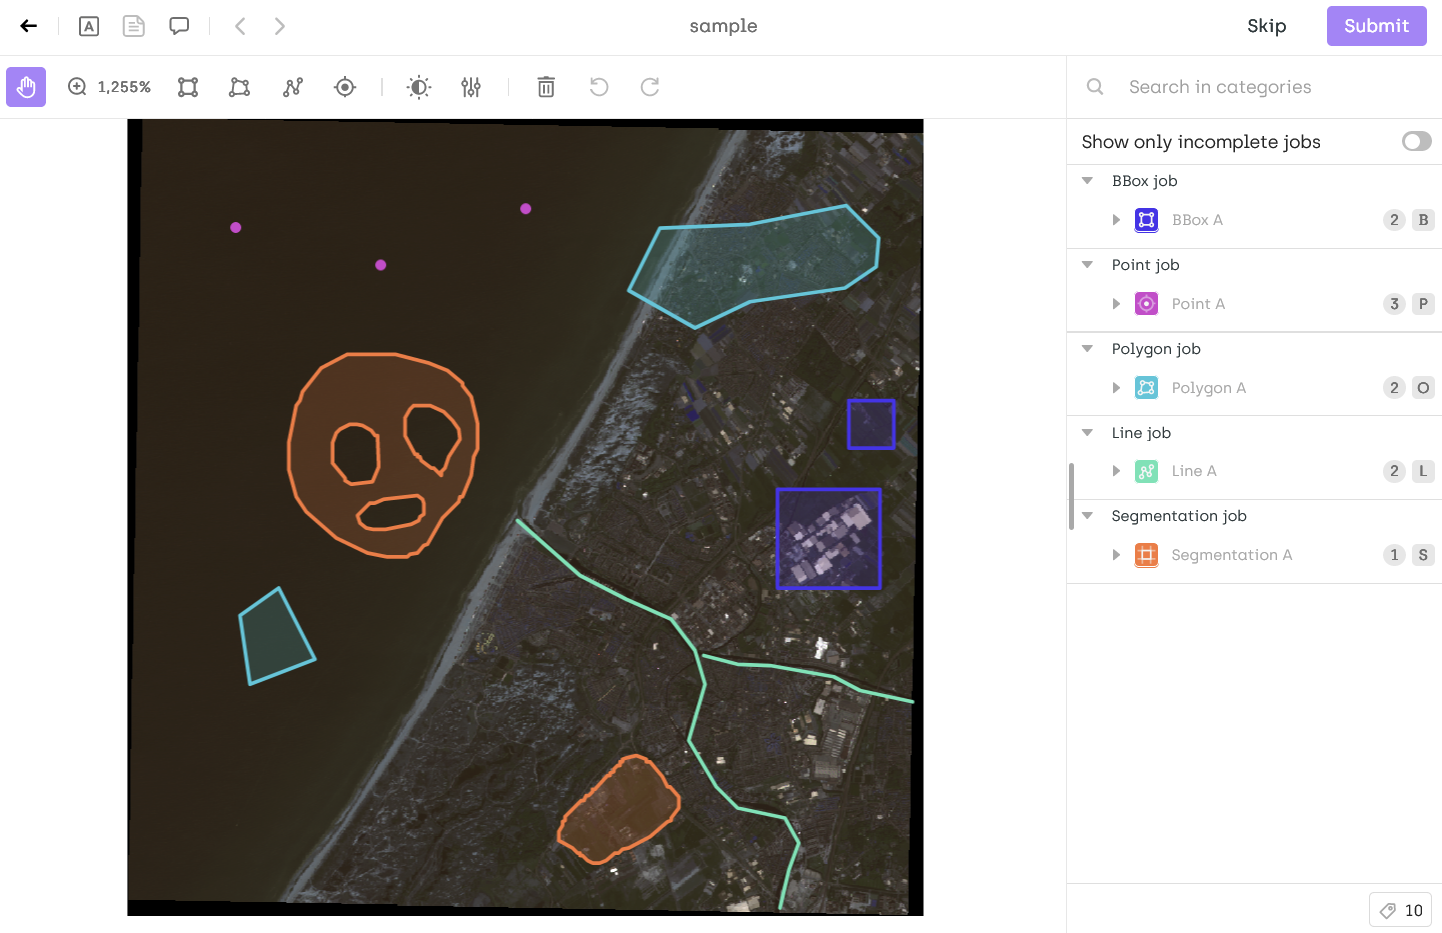

Remember that you can also use the Kili API to retrieve the label:

In [ ]:
label = kili.assets(
    project_id=project_id, fields=["latestLabel.jsonResponse"], label_output_format="parsed_label"
)[0]["latestLabel"]

## Kili labels to GeoJSON

Kili SDK provides a set of label utils to convert Kili labels to GeoJSON:

In [ ]:
from kili.utils.labels.geojson import (
    features_to_feature_collection,
    kili_bbox_annotation_to_geojson_polygon_feature,
    kili_json_response_to_feature_collection,
    kili_line_annotation_to_geojson_linestring_feature,
    kili_point_annotation_to_geojson_point_feature,
    kili_polygon_annotation_to_geojson_polygon_feature,
    kili_segmentation_annotation_to_geojson_polygon_feature,
)

Let's convert all annotations of this label to GeoJSON features:

In [ ]:
features = []

In [ ]:
for point_ann in label.jobs["POINT_DETECTION_JOB"].annotations:
    features.append(
        kili_point_annotation_to_geojson_point_feature(
            point_ann.as_dict(), job_name="POINT_DETECTION_JOB"
        )
    )

In [ ]:
for line_ann in label.jobs["LINE_DETECTION_JOB"].annotations:
    features.append(
        kili_line_annotation_to_geojson_linestring_feature(
            line_ann.as_dict(), job_name="LINE_DETECTION_JOB"
        )
    )

In [ ]:
for bbox_ann in label.jobs["BBOX_DETECTION_JOB"].annotations:
    features.append(
        kili_bbox_annotation_to_geojson_polygon_feature(
            bbox_ann.as_dict(), job_name="BBOX_DETECTION_JOB"
        )
    )

In [ ]:
for polygon_ann in label.jobs["POLYGON_DETECTION_JOB"].annotations:
    features.append(
        kili_polygon_annotation_to_geojson_polygon_feature(
            polygon_ann.as_dict(), job_name="POLYGON_DETECTION_JOB"
        )
    )

In [ ]:
for segmentation_ann in label.jobs["SEGMENTATION_JOB"].annotations:
    features.append(
        kili_segmentation_annotation_to_geojson_polygon_feature(
            segmentation_ann.as_dict(), job_name="SEGMENTATION_JOB"
        )
    )

Finally, we convert all features into a FeatureCollection:

In [ ]:
feature_collection = features_to_feature_collection(features)

In fact, you can even summarize all the code above with just one utility function:

In [ ]:
feature_collection = kili_json_response_to_feature_collection(label.json_response)

Note that if some jobs in your ontology cannot be converted to GeoJSON, the function will raise warnings and return a GeoJSON FeatureCollection with only the features that could be converted.

In [ ]:
with open("label.geojson", "w") as f:
    json.dump(feature_collection, f)

And we can visualize the GeoJSON file `label.geojson` with our annotations by uploading it to [geojson.io](https://geojson.io/#map=11.33/52.2094/4.4093):

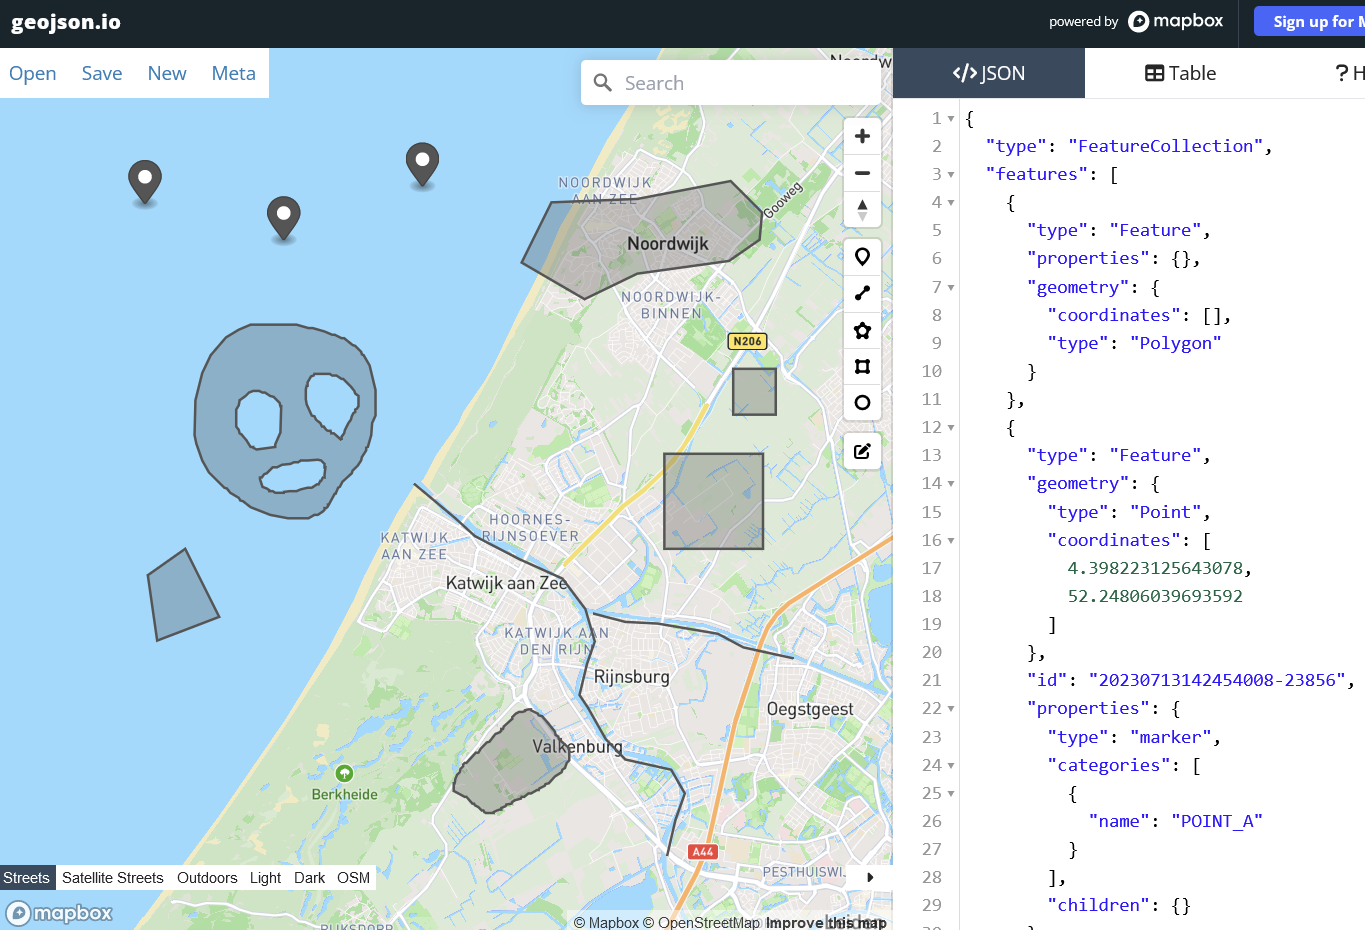

Note that the GeoJSON file also contains some of the Kili label metadata like the annotation mid, the categories, etc.

## GeoJSON to Kili labels

For this part, we will use GeoJSON annotations drawn on [geojson.io](https://geojson.io/#map=10.85/52.2112/4.3538).

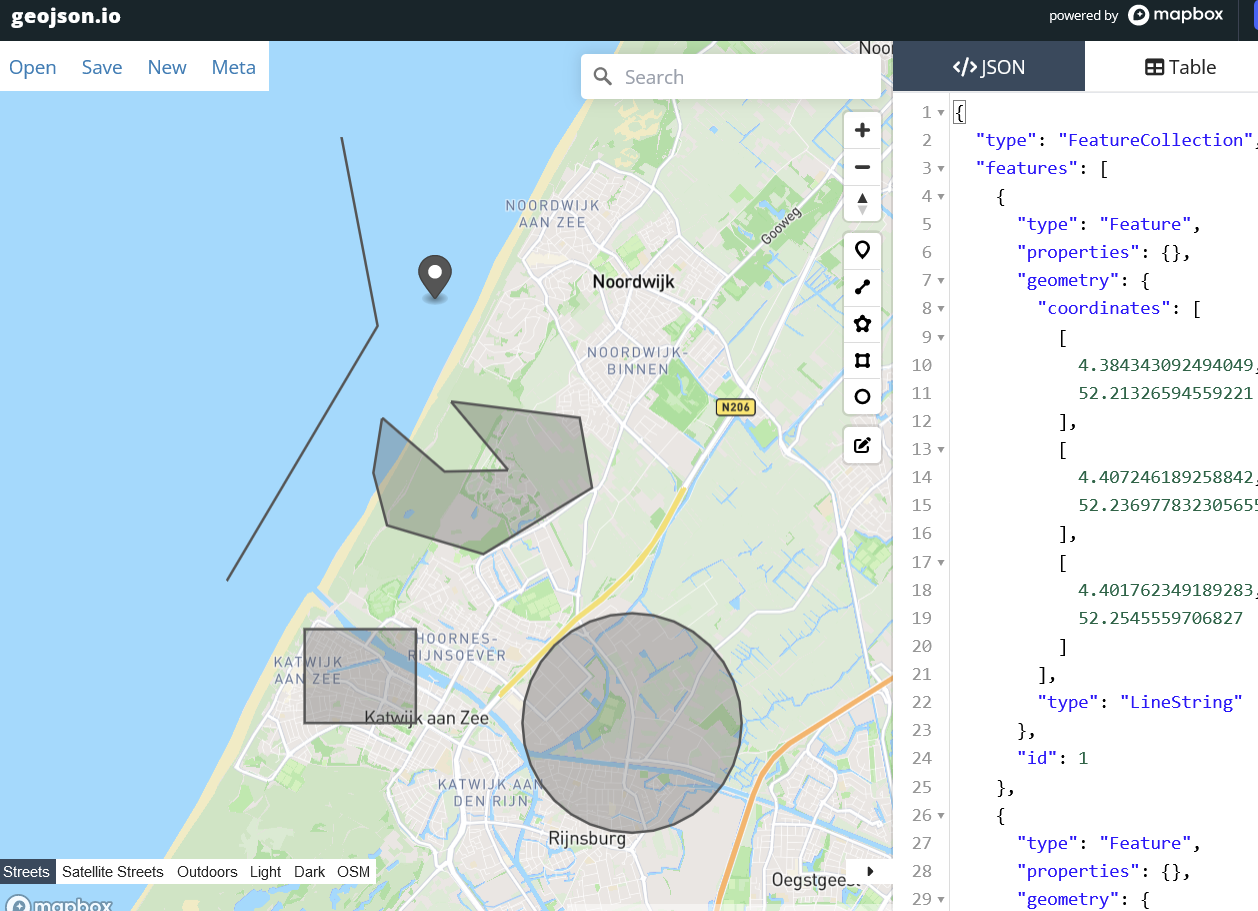

The geojson file can be download from our repository:

In [ ]:
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/kili-technology/kili-python-sdk/main/recipes/datasets/geojson_tutorial_geojson_label.geojson",
    "geojson_tutorial_geojson_label.geojson",
)

In [ ]:
with open("geojson_tutorial_geojson_label.geojson") as f:
    geojson_label = json.load(f)

A geojson label is usually composed of a FeatureCollection with a list of features. Each feature has a geometry and a set of properties.

In [ ]:
print(geojson_label.keys())
print(geojson_label["type"])

dict_keys(['features', 'type'])
FeatureCollection


We can now import the relevant Kili SDK functions to convert the GeoJSON file to Kili labels. Note that the Kili label format requires more information that a GeoJSON file usually contains like:

- the categories for each feature
- the job name of the annotation
- the tool used to annotate (marker, semantic, polygon, rectangle, etc.)

If the features in the GeoJSON file have a `properties` field with the `kili` key (which is the case when using the `kili_json_response_to_feature_collection` method), we could just use the `geojson_feature_collection_to_kili_json_response` method to directly get the Kili label json response.

However, since the GeoJSON file we are using does not have the `kili` key in the `properties` field, we will have to do the conversion manually for each GeoJSON feature.

In [ ]:
from kili.utils.labels.geojson import (
    geojson_linestring_feature_to_kili_line_annotation,
    geojson_point_feature_to_kili_point_annotation,
    geojson_polygon_feature_to_kili_bbox_annotation,
    geojson_polygon_feature_to_kili_polygon_annotation,
    geojson_polygon_feature_to_kili_segmentation_annotation,
)

In [ ]:
json_response = {}

for feature in geojson_label["features"]:
    geometry_type = feature["geometry"]["type"]

    if geometry_type == "Point":
        job_name = "POINT_DETECTION_JOB"
        category = "POINT_A"
        converter = geojson_point_feature_to_kili_point_annotation

    elif geometry_type == "Polygon":
        job_name = "POLYGON_DETECTION_JOB"
        category = "POLYGON_A"
        converter = geojson_polygon_feature_to_kili_polygon_annotation

    elif geometry_type == "LineString":
        job_name = "LINE_DETECTION_JOB"
        category = "LINE_A"
        converter = geojson_linestring_feature_to_kili_line_annotation

    else:
        raise ValueError(f"Geometry type {geometry_type} not supported")

    categories = [{"name": category}]  # put your own categories here

    kili_annotation = converter(feature, categories=categories)

    if job_name not in json_response:
        json_response[job_name] = {"annotations": []}

    json_response[job_name]["annotations"].append(kili_annotation)

Now that we have the Kili label json response, we can upload it to our Kili project:

In [ ]:
kili.append_labels(
    json_response_array=[json_response], project_id=project_id, asset_external_id_array=["sample"]
)

You can now visualize the annotations in Kili:

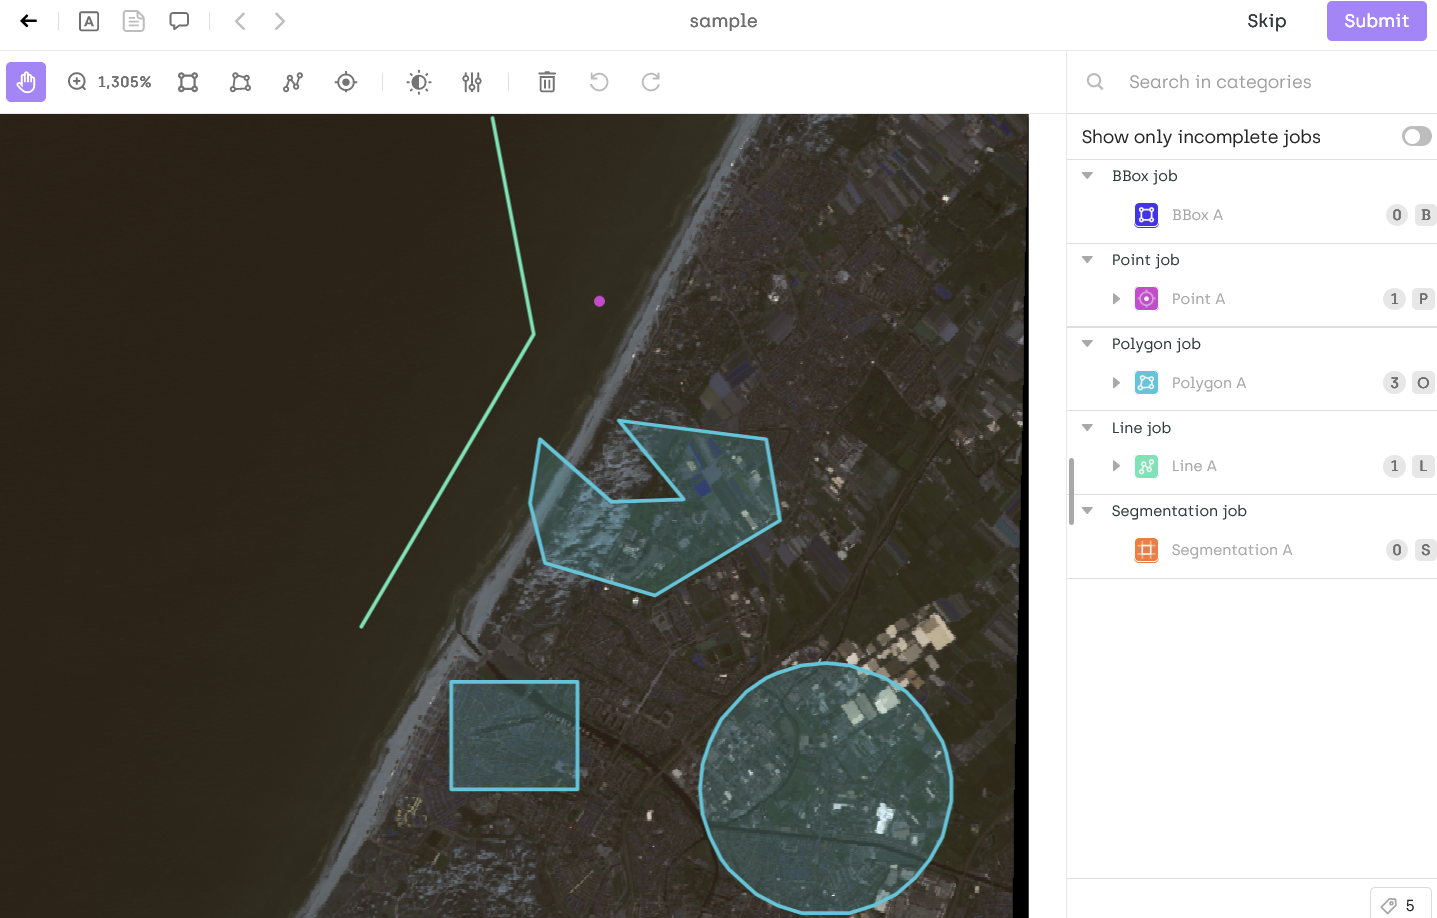

As you can see, all the polygons (bouding boxes, polygons, segmentations) have been assigned to the Polygon job, since the GeoJSON format does not differentiate between the different types of geometries.

If you want to assign the polygons to different jobs, you will have to do it manually by adding a `job` field in the `kili` key of the `properties` field of each feature.

## Conclusion

In this recipe, we saw how to convert Kili label format to GeoJSON.

For more information about the label utils for GeoJSON, please refer to the [documentation](https://python-sdk-docs.kili-technology.com/latest/sdk/label_utils/#geojson).

## Cleanup

In [ ]:
kili.delete_project(project_id)